In [1]:
import mne, os

In [2]:
def get_epochs(f):
    epochs = mne.read_epochs(f)
    montage = mne.channels.read_montage('easycap-M1',ch_names=epochs.ch_names)
    epochs.set_montage(montage)
    return epochs.set_eeg_reference(projection=True)

In [3]:
# for all subjects
subject = 'fsaverage'
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)
trans = os.path.join(fs_dir, 'bem', 'fsaverage-trans.fif')
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-3-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from /usr/local/miniconda3/envs/conda-eeg/lib/python3.7/site-packages/mne/datasets/_fsaverage/root.txt in /Users/fbaumgardt/mne_data/MNE-fsaverage-data
0 files missing from /usr/local/miniconda3/envs/conda-eeg/lib/python3.7/site-packages/mne/datasets/_fsaverage/bem.txt in /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage


In [5]:
# per subject
#raw = mne.io.read_raw_brainvision("../data/reinhartlab/probabilistic/Prob_EEGTest_016PS.vhdr")
epochs = get_epochs("../../data/reinhartlab/multimodal/cg/MulitModal_EEG_058CG-epo.fif.gz").apply_baseline((-.3,-.1)).crop(tmin=0.,tmax=1.)

Reading ../../data/reinhartlab/multimodal/cg/MulitModal_EEG_058CG-epo.fif.gz ...
    Found the data of interest:
        t =   -2500.00 ...    3500.00 ms
        0 CTF compensation matrices available
1216 matching events found
No baseline correction applied
Adding metadata with 5 columns
0 projection items activated
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Applying baseline correction (mode: mean)


In [8]:
fwd = mne.make_forward_solution(epochs.info, trans=trans, src=src, bem=bem, meg=False, mindist=5.0, n_jobs=1)
eeg_map = mne.sensitivity_map(fwd, ch_type='eeg', mode='fixed')
noise_cov = mne.compute_covariance(epochs)
mnest = mne.minimum_norm.make_inverse_operator(epochs.info,fwd,noise_cov,) # inverse 

Source space          : /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-3-src.fif
MRI -> head transform : /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-ico-3-src.fif...
Read 2 source spaces a total of 1284 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  60 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM mod

In [9]:
raw = mne.io.read_raw_fif("../../data/reinhartlab/multimodal/cg/MulitModal_EEG_058CG.raw.fif.gz",preload=True)
raw.set_montage(mne.channels.read_montage('easycap-M1',ch_names=epochs.ch_names))
raw,_ = mne.set_eeg_reference(raw,projection=True)

Opening raw data file ../../data/reinhartlab/multimodal/cg/MulitModal_EEG_058CG.raw.fif.gz...
    Range : 0 ... 4769779 =      0.000 ...  4769.779 secs
Ready.
Reading 0 ... 4769779  =      0.000 ...  4769.779 secs...
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


In [10]:

stc = mne.minimum_norm.apply_inverse_epochs(epochs,mnest,1.,method='dSPM',pick_ori=None,verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 59 (1 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 60 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 1216
combining the current components...
Processing epoch : 2 / 1216
combining the current components...
Processing epoch : 3 / 1216
combining the current components...
Processing epoch : 4 / 1216
combining the current components...
Processing epoch : 5 / 1216
combining the current components...
Processing epoch : 6 / 1216
combining the current components...
Processing epoch : 7 / 1216
combining the current components...
Processing epoch : 8 / 1216
combining the current components...
Processing epoch : 9 / 1216
combining t

In [11]:
snr = 3.0
lambda2 = 1.0 / snr ** 2
evoked = epochs.average()
stc = apply_inverse(evoked, inverse_operator, lambda2, method,
                    pick_ori="normal")

# Restrict the source estimate to the label in the left auditory cortex.
stc_label = stc.in_label(label_lh)

# Find number and index of vertex with most power.
src_pow = np.sum(stc_label.data ** 2, axis=1)
seed_vertno = stc_label.vertices[0][np.argmax(src_pow)]
seed_idx = np.searchsorted(stc.vertices[0], seed_vertno)  # index in orig stc

# Generate index parameter for seed-based connectivity analysis.
n_sources = stc.data.shape[0]
indices = seed_target_indices([seed_idx], np.arange(n_sources))

NameError: name 'apply_inverse' is not defined

In [ ]:
snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
stcs = apply_inverse_epochs(epochs, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

In [ ]:
fmin = (8., 13.)
fmax = (13., 30.)
sfreq = raw.info['sfreq']  # the sampling frequency

coh, freqs, times, n_epochs, n_tapers = spectral_connectivity(
    stcs, method='coh', mode='fourier', indices=indices,
    sfreq=sfreq, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)

print('Frequencies in Hz over which coherence was averaged for alpha: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for beta: ')
print(freqs[1])

In [12]:
label = mne.read_labels_from_annot(subject, parc='aparc',
                                   subjects_dir=subjects_dir,
                                   regexp='')
label

Reading labels from parcellation...
   read 1 labels from /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 1 labels from /Users/fbaumgardt/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


[<Label  |  fsaverage, 'bankssts-lh', lh : 2137 vertices>,
 <Label  |  fsaverage, 'bankssts-rh', rh : 2196 vertices>]

In [39]:
srces = np.matmul(mnest['eigen_leads']['data'],(np.array(mnest['info']['ch_names'])=='FCz')*1.)

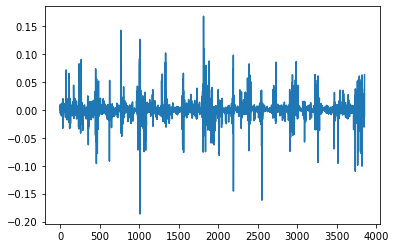

In [41]:
plt.plot(srces)

In [44]:
np.max(srces)*.9

0.15041422990834227

In [53]:
fcz_verts = np.argsort(srces)[-10:]

In [50]:
mnest['source_nn']

array([[-5.78612424e-17, -8.66472829e-01, -4.99224235e-01],
       [-7.61450823e-01,  3.23608472e-01, -5.61667341e-01],
       [-6.48222682e-01, -3.80134704e-01,  6.59776448e-01],
       ...,
       [-3.96907186e-17,  4.01293243e-01,  9.15949635e-01],
       [ 4.30008842e-01, -8.26941932e-01,  3.62297442e-01],
       [ 9.02824676e-01,  3.93866442e-01, -1.72559643e-01]])